# Load and Preprocess data

In [1]:
from collections import defaultdict
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

mndata = MNIST('../HW1/mnist')
trainData, trainLabel = mndata.load_training()
testData, testLabel = mndata.load_testing()

In [2]:
class data_process():
    def __init__(self, trainD, trainL, testD, testL, addBias = True, shuffle = True):
        self.trainData = np.asarray(trainD)
        self.testData = np.asarray(testD)
        self.trainLabel = np.asarray(trainL).reshape((len(trainL),-1))
        self.testLabel = np.asarray(testL).reshape((len(testL),-1))
        self.zScoring()
        if addBias:
            self.addBias()
        if shuffle:
            self.shuffle()
    def addBias(self):
        self.trainData = np.insert(np.asarray(self.trainData), 0, 1, axis=1)
        self.testData = np.insert(np.asarray(self.testData), 0, 1, axis=1)
    def shuffle(self):
        idxTrain = np.random.permutation(len(self.trainData))
        idxTest = np.random.permutation(len(self.testData))
        self.trainData = self.trainData[idxTrain]
        self.trainLabel = self.trainLabel[idxTrain]
        self.testData = self.testData[idxTest]
        self.testLabel = self.testLabel[idxTest]
    def zScoring(self):
        self.trainData = self.trainData / 127.5 - 1.0
        self.testData = self.testData / 127.5 - 1.0
    def oneHot(self):
        classes = len(np.unique(self.trainLabel))
        trainL = np.zeros((len(self.trainLabel), classes))
        testL = np.zeros((len(self.testLabel), classes))
        for i, label in enumerate(self.trainLabel):
            trainL[i][label] = 1
        for i, label in enumerate(self.testLabel):
            testL[i][label] = 1
        return trainL, testL

In [3]:
data = data_process(trainData, trainLabel, testData, testLabel, addBias = True, shuffle = True)

In [4]:
class multiLayerNN():
    def __init__(self, trainD, trainL, testD, testL, valid_rate = 0.1, nHiddenUnits = [100,], \
                 learning_rate = 1e-3, annealing_rate = 0., maxIter = 1000, earlyStop=False, \
                 batchSize = 1, regType = 'L2', lam = 0., momentum = 0.9, actFuns=("ReLU","softMax")):
        self.validLen = int(len(trainD) * valid_rate)
        self.trainD = trainD[self.validLen:]
        self.trainL = trainL[self.validLen:]
        self.validD = trainD[:self.validLen]
        self.validL = trainL[:self.validLen]
        self.testD = testD
        self.testL = testL
        self.batchSize = int(batchSize)
        self.lr = learning_rate
        self.maxIter = maxIter
        self.ar = annealing_rate
        self.mu = momentum
        self.lam = lam
        self.regType = regType
        self.earlyStop = earlyStop
        self.loss = defaultdict(list)
        self.err = defaultdict(list)
        self.weight = np.zeros((len(trainD[0]),1))
        self.best_err = np.ones((3,1))
        self.actFuns = actFuns
        self.nClass = len(np.unique(trainLabel))
        self.nLayer = len(nHiddenUnits) + 1
        self.nUnits = [self.trainD.shape[1]] + nHiddenUnits + [self.nClass]
        self.weights = [1 / np.sqrt(self.nUnits[i]) * np.random.randn(self.nUnits[i], self.nUnits[i + 1]) for i in range(self.nLayer)]
#         self.weights = self.fit()
        
    def fit(self):
        best_err = np.ones((3,1))
        best_weight = np.zeros((len(self.trainD[0]), 1))
        trainLen = self.trainD.shape[0]
        wRecords = [[] for _ in self.weights]
        v = [0 for _ in self.weights]
        epoch = 0
        while epoch < self.maxIter:
            idx = np.random.permutation(trainLen)
            if self.ar:
                lr = self.lr / (1.0 + epoch / self.ar)
            else:
                lr = self.lr
            loss = 0.0
            for startIdx in range(0, trainLen, self.batchSize):
                endIdx = startIdx + self.batchSize
                if endIdx >= trainLen:
                    endIdx = trainLen
                trainD = self.trainD[idx[startIdx:endIdx]]
                trainL = self.trainL[idx[startIdx:endIdx]]
                
                outputs = self.forwardProp(trainD)
                dW = self.backProp(trainD, trainL, outputs)
                loss += self.cal_loss(trainD, trainL) * len(trainD)
                
                
                for i in range(len(wRecords)):
                    wRecords[i].append(np.array(self.weights[i]))

                for j in range(len(self.weights)):
                    vPrev = v[i]
                    v[i] = self.mu * v[i] - lr * dW[i]
                    self.weights[i] += -self.mu * vPrev + (1 + self.mu) * v[i]
                
            self.loss['train'].append(loss / len(self.trainD))
            self.loss['valid'].append(self.cal_loss(self.validD, self.validL))
            self.loss['test'].append(self.cal_loss(self.testD, self.testL))
            
            self.err['train'].append(self.cal_err(self.trainD, self.trainL))
            self.err['valid'].append(self.cal_err(self.validD, self.validL))
            self.err['test'].append(self.cal_err(self.testD, self.testL)) 
            
            if epoch == 0 or epoch % 10 == 9:
                print ('Training set loss after %d epoch: %7.4f' % (epoch + 1, self.loss['train'][-1]))
                
            if best_err[1] >= self.err['valid'][-1]:
                best_err[0] = self.err['train'][-1]
                best_err[1] = self.err['valid'][-1]
                best_err[2] = self.err['test'][-1]
                best_weight = self.weight
                
            if self.earlyStop:
                if len(self.err['valid']) >= 30 and self.err['valid'][-1] > self.err['valid'][-2] > self.err['valid'][-3]:
                    print ("EarlyStop after %d epochs." % (epoch))
                    break
            epoch += 1
        self.weights = best_weight
        self.best_err = best_err
    
    # activation function
    #1. for hidden layer
    def ReLU(self, X, W):
        a = X.dot(W)
        return a * (a > 0)
    #2. for output layer
    def softMax(self, X, W):
        ak = X.dot(W)
        scores = np.exp(ak)
        return scores / np.sum(scores, axis=1, keepdims=True)

    def forwardProp(self, X):
        outputs = [X]
        for weight, actFun in zip(self.weights, self.actFuns):
            if actFun == "softMax":
                outputs.append(self.softMax(outputs[-1], weight))
            elif actFun == "ReLU":
                outputs.append(self.ReLU(outputs[-1], weight))
        return outputs[1:]
        
    def backProp(self, X, t, outputs):
        n = t.shape[0]
        dW = []
        outputs = [X] + outputs
        for i in range(len(self.weights) - 1, -1, -1):
            output1, output2 = outputs[i], outputs[i + 1]
            if self.actFuns[i] == "softMax":
                output2 -= t
                delta = output2 / n
                dW.append(output1.T.dot(delta))
            elif self.actFuns[i] == "ReLU":
                delta = (1. * (output2 > 0)) * self.weights[i + 1].dot(delta.T).T
                dW.append(output1.T.dot(delta))
        dW = dW[::-1]
        for i in range(len(self.weights)):
            if self.regType == "L2":
                regW = 2 * self.weights[i][1:] * self.lam
                regW = np.insert(regW, 0, 0.0, axis = 0)
                dW[i] += regW
            elif self.regType == "L1":
                regW = np.array(self.weights[i][1:])
                regW[regW > 0] = 1
                regW[regW < 0] = -1
                regW = np.insert(regW, 0, 0.0, axis = 0)
                dW[i] += self.lam * regW
        return dW
    
    def cal_err(self, data, label):
        outputs = self.forwardProp(data)
        output = outputs[-1]
        predict = np.argmax(output, axis = 1).reshape((len(output), -1))
        label = np.argmax(label, axis = 1).reshape((len(label),-1))
        err = 1.0 * np.sum([a != b for (a, b) in zip(predict, label)]) / len(label)
        return err
    
    def cal_loss(self, data, label):
        outputs = self.forwardProp(data)
        output = outputs[-1]
        loss = -1.0 * np.sum(np.nan_to_num(label * np.log(output)))
        
        for weight in self.weights:
            if self.regType == "L2":
                loss += self.lam * np.sum(np.power(weight[1:], 2))
            elif self.regType == "L1":
                loss += self.lam * np.sum(np.absolute(weight[1:]))

        loss = loss / len(data)
        return loss 
    
    def evalTest(self, xTest, tTest, weights = 0):
        if type(weights) is int:
            return self.evalLossError(xTest, tTest, self.W)
        else:
            return self.evalLossError(xTest, tTest, weights)
    
    def plot_loss(self, title = 'Loss of Multilayer Neural Networks'):
        x = [i for i in range(len(self.loss['valid']))]
        plt.figure(figsize = (8,6))
        trainLoss, = plt.plot(x, self.loss['train'])
        validLoss, = plt.plot(x, self.loss['valid'])
        testLoss, = plt.plot(x, self.loss['test'])
        plt.legend([trainLoss, validLoss, testLoss], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Loss')
#         plt.ylim([0.0, 0.5])
        plt.grid(True)
        plt.title(title)

    def plot_acc(self, title = 'Percent Correct Classification of Multilayer Neural Networks'):
        x = [i for i in range(len(self.err['valid']))]
        plt.figure(figsize = (8,6))
        trainAcc, = plt.plot(x, 1.0 - np.array(self.err['train']))
        validAcc, = plt.plot(x, 1.0 - np.array(self.err['valid']))
        testAcc, = plt.plot(x, 1.0 - np.array(self.err['test']))
        plt.legend([trainAcc, validAcc, testAcc], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Percent Correct Classification')
#         plt.ylim([0.8, 1.0])
        plt.grid(True)
        plt.title(title)

In [5]:
trainD, testD = data.trainData, data.testData
trainL, testL = data.oneHot()

In [8]:
# Hyperparameters
VALID_RATE = 0.1
LEARNING_RATE = 1e-3
LAMBDA = 1e-2
BATCH_SIZE = 1000
MAX_ITERATION = 200
EARLY_STOP = True
ANNEALING_RATE = 2e9
MOMENTUM = 0.9
REGULARIZATION_TYPE = 'L2'

Training set loss after 1 epoch:  2.2836
Training set loss after 10 epoch:  1.1727
Training set loss after 20 epoch:  0.9477
Training set loss after 30 epoch:  0.8697
Training set loss after 40 epoch:  0.8336
Training set loss after 50 epoch:  0.8145
Training set loss after 60 epoch:  0.8037
EarlyStop after 61 epochs.
The error rate when it is lowest on validation set: 
 train:  0.1841;
 validation:  0.1915;
 test:  0.1722.


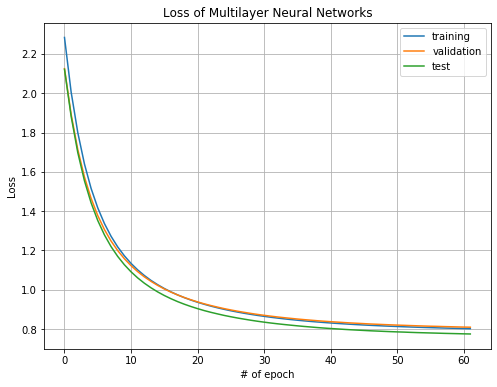

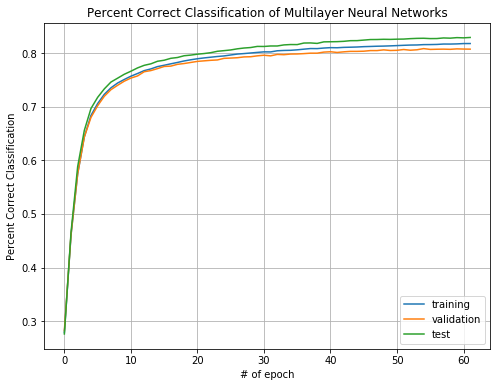

In [9]:
model = multiLayerNN(trainD, trainL, testD, testL, valid_rate = VALID_RATE,  nHiddenUnits = [128], \
                           learning_rate = LEARNING_RATE, annealing_rate = ANNEALING_RATE, maxIter = MAX_ITERATION, \
                           earlyStop = EARLY_STOP, batchSize = BATCH_SIZE, regType = REGULARIZATION_TYPE, \
                           lam = LAMBDA, momentum = MOMENTUM, actFuns=("ReLU", "softMax"))

model.fit()

print ('The error rate when it is lowest on validation set: \n train: %7.4f;\n validation: %7.4f;\n test: %7.4f.' \
       % (model.best_err[0], model.best_err[1], model.best_err[2]))

model.plot_loss()

model.plot_acc()
plt.show()